# Final Project 8/12
 - langgraph 기초 구현을 위한 코드입니다.


## Import Packages

In [1]:
from typing import TypedDict, Annotated, Dict, Optional
import operator
import json
import ast
import pandas as pd

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough, RunnableMap
from langchain.memory import ConversationSummaryBufferMemory
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

## Define State

In [2]:
# 딕셔너리 병합 함수
def merge_dicts(dict1, dict2):
    merged = dict1.copy()  # dict1을 복사하여 새로운 딕셔너리를 생성
    merged.update(dict2)   # dict2의 키와 값을 병합
    return merged

In [3]:
# 첫 질문에 대한 클래스
class LangState(TypedDict):
    model: Optional[ChatOpenAI]
    question: Annotated[str, operator.add]  # 사용자의 입력질문
    keywords: Annotated[Dict[str, str], merge_dicts]#operator.add]  # 입력질문으로 뽑아낸 키워드
    hotel_context: Annotated[Dict[str, str], merge_dicts]#operator.add]  # 뽑힌 여행지들
    scheduler: Annotated[Dict[str, str], merge_dicts]  # 최종 여행지
    sql_query: Annotated[str, operator.add]  # 키워드를 기반으로 db 조회하는 쿼리
    second_sentence: Annotated[str, operator.add]  # 검증


## Define Functions

In [4]:
# 실제로는 sql을 조회하게 될 함수
def get_db():
    food = pd.read_csv("./busan_data/spot_busan.csv")
    food = food['업체명']
    return food

## Define Nodes

In [5]:
def make_keyword(state: LangState) -> LangState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to classify the sentence as follows: 
        ====
        def classify(sentence: str) -> ['days(Integer)', 'type(str)']:     
            # Classify the sentence as how much days human want to go trip, how many people go trip, and what kind of trip human want from Args.
            # If you can't classify then each values can replace [3, 3, 'vacation']
            Args:       sentence(str): The sentence that is classified.     
            Return:    ['days(Integer)', 'type(str)']: The classification of sentence.     
        ====
        # Get result     
        result = classify_sentence(sentence)    
        return result
        ====
        #Response format
        classify("{question}")
        """),
        ("human", "{question}")
    ])
    chain = prompt | state['model']
    result = chain.invoke({"question": state['question']})
    response = result.content

    return LangState(keywords=response)

def db_search(state: LangState) -> LangState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to search the places as follows:
         ====
         def search(places: csv or MariaDB, user_input: list) -> ['attractions': places(str)(numbers = days * 2 * 3), 'restaurants': places(str)(numbers = days * 3 * 3), 'hotels': places(str)(numbers = days * 3)]:
            # Search the places from database for days * 2 * k attractions, days * 3 * k restaurants, days * 1 * k hotels following the type.
            # Based on the type, if the type is related to attractions, search attractions first and then find the rest of the places(attractions, hotels, restaurants) within a 5km radius considering latitude and longitude until the requested number is reached.
            # If the type is related to restaurants or hotels, then please search for the related thing first like upper sentence.
            # If the type is None or Thing that you can't understand, then just consider attractions and search the places.
            Args:       places(csv file) and user_input(list): the places from database, and user_input is from state['keyword']
            Return: ['attractions': places(str)(numbers = days * 2 * 3), 'restaurants': places(str)(numbers = days * 3 * 3), 'hotels': places(str)(numbers = days * 3)]: The Search Result
        ====
         # Get result
         result = search_places({db}, {user})
         return result
         ====
         #Response format
         search("{db},{user}")
         answer = {    }
        """),
        ("human", "{user}")
    ])
    chain = RunnablePassthrough.assign(db=get_db) | prompt | state['model']
    result = chain.invoke({"user": state['keywords']})
    response = result.content
    # 추가구현필요
    response = None
    return LangState(context=response)

def make_schedule(state: LangState) -> LangState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to generate a travel itinerary based on the provided data and requirements.
        ====
        def generate_itinerary(data: dict, days: int) -> dict:
            Generates a travel itinerary for 'n' days using the provided data. The itinerary should be returned in JSON format and follow these guidelines:
            
            - Each day's itinerary includes breakfast, lunch, and dinner (breakfast and lunch must be at restaurants, dinner can be at a restaurant or bar).
            - Each day includes visits to 2 different tourist spots.
            - A different hotel is assigned each night, with a maximum of 3 consecutive nights at the same hotel.
            - The itinerary starts with a day at Busan Station (not included as a tourist spot) and ends with the last day at Busan Station (without a hotel).
            - The itinerary should be slightly different each time it is generated, with random selections of restaurants, tourist spots, and hotels.
            - The JSON should use the day number as the key and the itinerary for that day as the value.
            - The last day should not include a hotel.
            
            Args:
                data (dict): The data containing information on restaurants, tourist spots, and hotels.
                days (int): The number of days for the itinerary.
                
            Returns:
                dict: A JSON-formatted dictionary representing the travel itinerary.

        # Example usage
        itinerary = generate_itinerary(data, days)
        return itinerary

        ====
        #Response format
        generate_itinerary({data}, {days})
        answer = {...}
        ====
        """)
    ])
    result = None
    return LangState(scheduler=result)

def validation(state: LangState) -> LangState:
    second_input = None
    return LangState(second_sentence=second_input)

In [6]:
def is_do_again(state: LangState) -> LangState:
    # 끝났는지 검사
    sent = LangState['second_sentence']
    if  sent == 'pass':
        return 'no'
    elif sent == 'go_first':
        return 'reset'
    elif sent == 'search_again':
        return 'again'
    elif sent == 'make_other':
        return 'other'
    return 'no'

In [7]:
# get StateGraph & END from langgraph.graph
workflow = StateGraph(LangState)

# Add Nodes
workflow.add_node('keywording', make_keyword)
workflow.add_node('searching', db_search)
workflow.add_node('scheduling', make_schedule)
workflow.add_node('validating', validation)

# Link Nodes
workflow.add_edge('keywording', 'searching')
workflow.add_edge('searching', 'scheduling')
workflow.add_edge('scheduling', 'validating')

# Add Conditional Edges
workflow.add_conditional_edges(
    "validating",
    is_do_again,
    {
        'no' : END,
        'reset': 'keywording',
        'again': 'searching',
        'other': 'scheduling'
    },
)

# Set Start Point
workflow.set_entry_point("keywording")

# Set Memory for Log
memory = MemorySaver()

# Compile Graph
app = workflow.compile(checkpointer=memory)

### Config 선언

In [8]:
config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

## Graph View

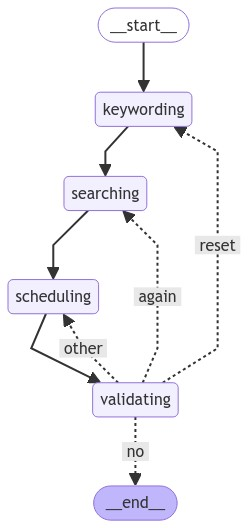

In [9]:
try:
    display(
        Image(app.get_graph(xray = True).draw_mermaid_png())
    ) # 실행 가능한 객체 그래프를 mermaid 형식의 PNG로 그려줌
    # xray = True -> 추가 세부 정보 포함
except:
    # 이 부분은 추가적인 의존성 필요, 선택적 실행
    pass

# Main

### LLM Model API KEY & MODEL

In [11]:
api_key = 'sk-_QhnbyR5USlFg_jiqyDQPFv1PSsYsZhnh_CC6aRqsMT3BlbkFJ60XrmvdXqfLPC00eWX0iQU1tI4qgfLtm3ENrKMVCsA'
# model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")

### Define Running Function

In [12]:
def running(input, LangState, model):
    inputs = LangState(question=input, model=model)
    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        for output in app.stream(inputs, config=config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    except GraphRecursionError as e:
        pprint.pprint(f"Recursion limit reached: {e}")

### Test

In [14]:
lg = LangState
m = model

In [15]:
#i = input("어떤 여행을 계획하시나요? ")
i = "안녕 나는 친구들이랑 부산 일주일 여행을 갈거야. 쉬러가고싶어"
# running(i, lg, m)

# Experiment

## Node 1. Keywords

In [16]:
prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to classify the sentence as follows: 
        ====
        def classify(sentence: str) -> ['days(Integer)', 'type(str)']:     
            # Classify the sentence as how much days human want to go trip, how many people go trip, and what kind of trip human want from Args.
            # If you can't classify then each values can replace [3, 3, 'vacation']
            Args:       sentence(str): The sentence that is classified.     
            Return:    ['days(Integer)', 'type(str)']: The classification of sentence.     
        ====
        # Get result     
        result = classify_sentence(sentence)    
        return result
        ====
        #Response format
        classify("{question}")
        """),
        ("human", "{question}")
])
chain = prompt | model
result = chain.invoke({"question": i})
response1 = result.content
list_data = ast.literal_eval(response1)
#json_data = json.dumps(list_data)
response1 = list_data
#response1 = json.load(response1)

In [ ]:
int(list_data[0])

In [17]:
response1

['7', 'vacation']

## Node 2. Search_DB

In [19]:
db = get_db().to_json(orient="records")  # DataFrame을 JSON 문자열로 변환
#db = get_db().to_json
prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to search the places as follows:
         ====
         def search(places: csv or MariaDB, user_input: list) -> dict['attractions': places(str)(numbers = days * 2 * 3), 'restaurants': places(str)(numbers = days * 3 * 3), 'hotels': places(str)(numbers = days * 3)]:
            # Search the places from database for days * 2 * k attractions, days * 3 * k restaurants, days * 1 * k hotels following the type.
            # Based on the type, if the type is related to attractions, search attractions first and then find the rest of the places(attractions, hotels, restaurants) within a 5km radius considering latitude and longitude until the requested number is reached.
            # If the type is related to restaurants or hotels, then please search for the related thing first like upper sentence.
            # If the type is None or Thing that you can't understand, then just consider attractions and search the places.
            # You only return dict type result, and places name is written by korean.(maybe you just use db original.)
            Args:       places(csv file) and user_input(list): the places from database, and user_input is from state['keyword']
            Return: dict['attractions': places(str)(numbers = days * 2 * 3), 'restaurants': places(str)(numbers = days * 3 * 3), 'hotels': places(str)(numbers = days * 3)]: The Search Result
        ====
         # Get result
         result = search_places({db}, {user})
         return result
         ====
         #Response format
         search("{db},{user}")
        """),
        ("human", "{db}, {user}")
    ])
chain = prompt | model
result = chain.invoke({"db": db, "user": response1})
response2 = result.content

In [ ]:
#db = get_db().to_json(orient="records")  # DataFrame을 JSON 문자열로 변환
#db = get_db().to_json
prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to search the places as follows:
         ====
         def search(places: csv or MariaDB, user_input: list) -> list['attractions': places(str)(numbers = days * 2 * 3)]:
            # Search the places from database for days * 2 * k attractions following the type and not translate.
            # Based on the type, if the type is related to attractions, search attractions first and then find the rest of the places(attractions, hotels, restaurants) within a 5km radius considering latitude and longitude until the requested number is reached.
            # If the type is related to restaurants or hotels, then please search for the related thing first like upper sentence.
            # If the type is None or Thing that you can't understand, then just consider attractions and search the places.
            # You only return dict type result, and places name is written by korean.(maybe you just use db original.)
            Args:       places(csv file) and user_input(list): the places from database, and user_input is from state['keyword']
            Return: list['attractions': places(str)(numbers = days * 2 * 3)]: The Search Result
        ====
         # Get result
         result = search_places({db}, {user})
         return result
         ====
         #Response format
         search("{db},{user}")
        """),
        ("human", "{db}, {user}")
    ])
chain = prompt | model
result = chain.invoke({"db": db, "user": response1})
response2 = result.content

In [20]:
response2

'```json\n{\n    "attractions": [\n        "보라비스프레차",\n        "제일란시티",\n        "강동에이스패트미트프레임",\n        "강서해수욕",\n        "강서해수욕장",\n        "부천팝",\n        "밤산수물안내",\n        "시세티미리",\n        "정거마를미화거리",\n        "마탱시티",\n        "노동강레시피",\n        "강서노동센터",\n        "모수현의가리",\n        "강서목록",\n        "모탱",\n        "노동강스미쿼리",\n        "강서보드게임",\n        "강서보드게임",\n        "강서보드게임",\n        "CGN알리원리온",\n        "부산스미치",\n        "월페타마타",\n        "에코네타",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n        "도시의미",\n       

## Node 3. Make Schedule

In [ ]:
prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to generate a travel itinerary based on the provided data and requirements.
        ====
        def generate_itinerary(data: dict, days: int) -> dict:
            Generates a travel itinerary for 'n' days using the provided data. The itinerary should be returned in JSON format and follow these guidelines:
            
            - Each day's itinerary includes breakfast, lunch, and dinner (breakfast and lunch must be at restaurants, dinner can be at a restaurant or bar).
            - Each day includes visits to 2 different tourist spots.
            - A different hotel is assigned each night, with a maximum of 3 consecutive nights at the same hotel.
            - The itinerary starts with a day at Busan Station (not included as a tourist spot) and ends with the last day at Busan Station (without a hotel).
            - The itinerary should be slightly different each time it is generated, with random selections of restaurants, tourist spots, and hotels.
            - The JSON should use the day number as the key and the itinerary for that day as the value.
            - The last day should not include a hotel.
            
            Args:
                data (dict): The data containing information on restaurants, tourist spots, and hotels.
                days (int): The number of days for the itinerary.
                
            Returns:
                dict: A JSON-formatted dictionary representing the travel itinerary.

        # Example usage
        itinerary = generate_itinerary(data, days)
        return itinerary

        ====
        #Response format
        generate_itinerary({data}, {days})
        ====
        """),
        ("human","{data}, {days}")
    ])
chain = prompt | model
result = chain.invoke({"data": response2, "days": response1[0]})
result = result.content

In [ ]:
result

## Node 4. Validation

In [ ]:
prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to classify the sentence into one of the following categories: ["other", "again", "reset", "no"]
        ====
        def classify(sentence: str) -> Literal["other", "again", "reset", "no"]:
            Classify the sentence into one of the following categories based on the user's intent:

            - "reset": The user wants to start over or re-enter information. Examples include phrases like '처음부터 할래' or '다시 입력하게 해줘'.
            - "again": The user wants to search again or is unsatisfied with the current result. Examples include phrases like '다시 찾아줘' or '여기 별로야'.
            - "no": The user is satisfied or wants to move forward. Examples include phrases like '알겠어' or '좋아'.
            - "other": The user's intent does not clearly fall into the above categories, or they request a different combination of the data.
            
            Args:
                sentence (str): The sentence that needs to be classified.
            
            Returns:
                Literal["other", "again", "reset", "no"]: The classification of the sentence.
        ====
        # Get result
        result = classify_sentence(sentence)
        return result

        ====
        # Response format
        classify("{human}")
        """),
    ("human", "{human}")
    ])
chain = prompt | model
answering = chain.invoke({"human": input("어때요?")})
answering = answering.content

In [ ]:
answering

# Test Graph

In [ ]:
from typing import TypedDict, Annotated, Dict, Optional, List
import operator
import json
import ast
import pandas as pd

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough, RunnableMap
from langchain.memory import ConversationSummaryBufferMemory
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

In [ ]:
# 딕셔너리 병합 함수
def merge_dicts(dict1, dict2):
    merged = dict1.copy()  # dict1을 복사하여 새로운 딕셔너리를 생성
    merged.update(dict2)   # dict2의 키와 값을 병합
    return merged

In [ ]:
# 첫 질문에 대한 클래스
class LangState(TypedDict):
    model: Optional[ChatOpenAI]
    question: Annotated[str, operator.add]  # 사용자의 입력질문
    keywords: Annotated[List[str], operator.add]# Annotated[Dict[str, str], merge_dicts]#operator.add]  # 입력질문으로 뽑아낸 키워드
    hotel_context: Annotated[List[str], operator.add]  # 뽑힌 여행지들
    foods_context: Annotated[List[str], operator.add]  # 뽑힌 여행지들
    view_context: Annotated[List[str], operator.add]  # 뽑힌 여행지들
    scheduler: Annotated[Dict[str, str], merge_dicts]  # 최종 여행지
    sql_query: Annotated[str, operator.add]  # 키워드를 기반으로 db 조회하는 쿼리
    second_sentence: Annotated[str, operator.add]  # 검증


In [ ]:
# 실제로는 sql을 조회하게 될 함수
def get_db():
    food = pd.read_csv("./busan_data/spot_busan.csv")
    food = food['업체명']
    return food

In [ ]:
def make_keyword(state: LangState) -> LangState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to classify the sentence as follows: 
        ====
        def classify(sentence: str) -> ['days(Integer)', 'type(str)']:     
            # Classify the sentence as how much days human want to go trip, how many people go trip, and what kind of trip human want from Args.
            # If you can't classify then each values can replace [3, 3, 'vacation']
            Args:       sentence(str): The sentence that is classified.     
            Return:    ['days(Integer)', 'type(str)']: The classification of sentence.     
        ====
        # Get result     
        result = classify_sentence(sentence)    
        return result
        ====
        #Response format
        classify("{question}")
        """),
        ("human", "{question}")
    ])
    chain = prompt | model
    result = chain.invoke({"question": state['question']})
    response = result.content
    response = ast.literal_eval(response)

    return LangState(keywords=response)

def db_search(state: LangState) -> LangState:
    db = get_db().to_json(orient="records")  # DataFrame을 JSON 문자열로 변환
    #db = get_db().to_json
    prompt = ChatPromptTemplate.from_messages([
            ("system", """
            Your task is to search the places as follows:
            ====
            def search(places: csv or MariaDB, user_input: list) -> ['attractions': places(str)(numbers = days * 2 * 3), 'restaurants': places(str)(numbers = days * 3 * 3), 'hotels': places(str)(numbers = days * 3)]:
                # Search the places from database for days * 2 * k attractions, days * 3 * k restaurants, days * 1 * k hotels following the type.
                # Based on the type, if the type is related to attractions, search attractions first and then find the rest of the places(attractions, hotels, restaurants) within a 5km radius considering latitude and longitude until the requested number is reached.
                # If the type is related to restaurants or hotels, then please search for the related thing first like upper sentence.
                # If the type is None or Thing that you can't understand, then just consider attractions and search the places.
                Args:       places(csv file) and user_input(list): the places from database, and user_input is from state['keyword']
                Return: ['attractions': places(str)(numbers = days * 2 * 3), 'restaurants': places(str)(numbers = days * 3 * 3), 'hotels': places(str)(numbers = days * 3)]: The Search Result
            ====
            # Get result
            result = search_places({db}, {user})
            return result
            ====
            #Response format
            search("{db},{user}")
            """),
            ("human", "{user}")
        ])
    chain = prompt | model
    result = chain.invoke({"db": db, "user": state["keywords"]})
    response = result.content
    return LangState(context=response)

def make_schedule(state: LangState) -> LangState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to generate a travel itinerary based on the provided data and requirements.
        ====
        def generate_itinerary(data: dict, days: int) -> dict:
            Generates a travel itinerary for 'n' days using the provided data. The itinerary should be returned in JSON format and follow these guidelines:
            
            - Each day's itinerary includes breakfast, lunch, and dinner (breakfast and lunch must be at restaurants, dinner can be at a restaurant or bar).
            - Each day includes visits to 2 different tourist spots.
            - A different hotel is assigned each night, with a maximum of 3 consecutive nights at the same hotel.
            - The itinerary starts with a day at Busan Station (not included as a tourist spot) and ends with the last day at Busan Station (without a hotel).
            - The itinerary should be slightly different each time it is generated, with random selections of restaurants, tourist spots, and hotels.
            - The JSON should use the day number as the key and the itinerary for that day as the value.
            - The last day should not include a hotel.
            
            Args:
                data (dict): The data containing information on restaurants, tourist spots, and hotels.
                days (int): The number of days for the itinerary.
                
            Returns:
                dict: A JSON-formatted dictionary representing the travel itinerary.

        # Example usage
        itinerary = generate_itinerary(data, days)
        return itinerary

        ====
        #Response format
        generate_itinerary({data}, {days})
        ====
        """),
        ("human","{data}, {days}")
    ])
    chain = prompt | model
    result = chain.invoke({"data": state["context"], "days": state["keywords"][0]})
    result = result.content
    return LangState(scheduler=result)

def validation(state: LangState) -> LangState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
        Your task is to classify the sentence into one of the following categories: ["other", "again", "reset", "no"]
        ====
        def classify(sentence: str) -> Literal["other", "again", "reset", "no"]:
            Classify the sentence into one of the following categories based on the user's intent:

            - "reset": The user wants to start over or re-enter information. Examples include phrases like '처음부터 할래' or '다시 입력하게 해줘'.
            - "again": The user wants to search again or is unsatisfied with the current result. Examples include phrases like '다시 찾아줘' or '여기 별로야'.
            - "no": The user is satisfied or wants to move forward. Examples include phrases like '알겠어' or '좋아'.
            - "other": The user's intent does not clearly fall into the above categories, or they request a different combination of the data.
            
            Args:
                sentence (str): The sentence that needs to be classified.
            
            Returns:
                Literal["other", "again", "reset", "no"]: The classification of the sentence.
        ====
        # Get result
        result = classify_sentence(sentence)
        return result

        ====
        # Response format
        classify("{human}")
        """),
    ("human", "{human}")
    ])
    chain = prompt | model
    answering = chain.invoke({"human": input("어때요?")})
    answering = answering.content
    return LangState(second_sentence=answering)

def is_do_again(state: LangState) -> LangState:
    # 끝났는지 검사
    sent = LangState['second_sentence']
    if  sent == 'pass':
        return 'no'
    elif sent == 'go_first':
        return 'reset'
    elif sent == 'search_again':
        return 'again'
    elif sent == 'make_other':
        return 'other'
    return 'no'


# get StateGraph & END from langgraph.graph
workflow = StateGraph(LangState)

# Add Nodes
workflow.add_node('keywording', make_keyword)
workflow.add_node('searching', db_search)
workflow.add_node('scheduling', make_schedule)
workflow.add_node('validating', validation)

# Link Nodes
workflow.add_edge('keywording', 'searching')
workflow.add_edge('searching', 'scheduling')
workflow.add_edge('scheduling', 'validating')

# Add Conditional Edges
workflow.add_conditional_edges(
    "validating",
    is_do_again,
    {
        'no' : END,
        'reset': 'keywording',
        'again': 'searching',
        'other': 'scheduling'
    },
)

# Set Start Point
workflow.set_entry_point("keywording")

# Set Memory for Log
memory = MemorySaver()

# Compile Graph
app = workflow.compile(checkpointer=memory)

config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

In [ ]:
try:
    display(
        Image(app.get_graph(xray = True).draw_mermaid_png())
    ) # 실행 가능한 객체 그래프를 mermaid 형식의 PNG로 그려줌
    # xray = True -> 추가 세부 정보 포함
except:
    # 이 부분은 추가적인 의존성 필요, 선택적 실행
    pass

In [ ]:
api_key = 'sk-_QhnbyR5USlFg_jiqyDQPFv1PSsYsZhnh_CC6aRqsMT3BlbkFJ60XrmvdXqfLPC00eWX0iQU1tI4qgfLtm3ENrKMVCsA'
# model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-3.5-turbo")
model = ChatOpenAI(api_key=api_key, temperature=0.1, model="gpt-4o-mini")

In [ ]:
def running(input, LangState, model):
    inputs = LangState(question=input, model=model)
    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        for output in app.stream(inputs, config=config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    except GraphRecursionError as e:
        pprint.pprint(f"Recursion limit reached: {e}")

In [ ]:
lg = LangState
m = model

In [ ]:
#i = input("어떤 여행을 계획하시나요? ")
i = "안녕 나는 친구들이랑 부산 일주일 여행을 갈거야. 바다보고싶어"
# running(i, lg, m)

In [ ]:
running(i, lg, m)